## Exploratory Data Analysis and Feature Engineering
Here we work with adjusted options data from the `data/adjusted_options` directory. First, we logically select features we need and clean them as needed. Then we will do basic visualizations and explore various edge cases of newly appearing and disappearing option listings.
<br>
<br>
**Importing required packages & changing working directory**

In [27]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import os
import datetime
from pathlib import Path

if os.getcwd()[-3:] == "src":
    os.chdir(os.path.dirname(os.getcwd()))
else:
    pass

**User defined parameters**

In [28]:
stock_of_interest = "CVX"
option_data_path = "data/adjusted_options/"
stock_data_path = "data/adjusted_daily_closing/"
default_save_path = "data/EDA/"
num_bars = 100

**Load adjusted options data**

In [29]:
try:
    options_df = pd.read_csv(os.path.abspath(os.path.join(option_data_path, (stock_of_interest + ".csv"))))
    options_df["date"] = pd.to_datetime(options_df["date"]).dt.date
    options_df["expiration date"] = pd.to_datetime(options_df["expiration date"]).dt.date
except FileNotFoundError:
    raise SystemExit("Option data for " + stock_of_interest + " not found in path: " +
                     os.path.abspath(os.path.join(option_data_path, stock_of_interest)) + ".csv")


First off, it is important to point out that we are only using `bid price` or `last price` as a measure of an option's value. This is because, we are focused on the selling of options, and `ask price` is an exaggerated representation of demand.

Thus, we first remove options that neither have bid nor last price, as we cannot determine demand. In addition, we will also remove options that have neither volume nor open interest. I made this decision because I believe that options that have no holders and liquidity is not representative of the market, as the `last price` may be outdated and `bid price` undervalued.

In [30]:
options_df = options_df[(options_df[["bid price", "last price"]].max(axis=1) > 0) &
                        (options_df[["volume", "open interest"]].max(axis=1) > 0)]
options_df.head()

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp date closing price,date div,exp date div
9,2016-01-04,2016-01-08,put,65.0,0.25,173.0,0.00,0.0,0.01,0.0,13.0,88.85,82.13,0.578852,0.649016
10,2016-01-04,2016-01-08,call,70.0,19.15,27.0,17.45,344.0,10.83,0.0,1.0,88.85,82.13,0.578852,0.649016
11,2016-01-04,2016-01-08,put,70.0,0.03,28.0,0.00,0.0,0.04,0.0,173.0,88.85,82.13,0.578852,0.649016
13,2016-01-04,2016-01-08,put,75.0,0.05,418.0,0.01,36.0,0.02,162.0,1506.0,88.85,82.13,0.578852,0.649016
15,2016-01-04,2016-01-08,put,76.5,0.04,117.0,0.02,25.0,0.02,291.0,11.0,88.85,82.13,0.578852,0.649016


Since the option strike price, closing price on current and expiration dates all contain priced in dividends, we will remove these with the pre-calculated dividend contributions, which was calculated in script `scrape_and_preprocess.py`.

Although removing dividend from the strike price might seem strange at first, since it is a fixed price to be executed at, we deem this is not the case. For example, a stock paying $5 quarterly dividends just passed its ex-div date and is valued at $10. Now to price a $15 call option expiring a day before the next ex-div date. Even though it might seem extremely OTM, in reality, it is the price the stock will be if no other external factors are at play (10 + 5 = 15).

In [31]:
options_df["adj closing"] = options_df["closing price"] - options_df["date div"]
options_df["adj strike"] = options_df["strike price"] - options_df["exp date div"]
options_df["adj exp closing"] = options_df["exp date closing price"] - options_df["exp date div"]
options_df["days till exp"] = np.busday_count(begindates=options_df["date"],
                                              enddates=options_df["expiration date"])
options_df = options_df.drop(columns=["date div", "exp date div"])

options_df.head()

,date,expiration date,type,strike price,ask price,ask size,bid price,bid size,last price,volume,open interest,closing price,exp date closing price,adj closing,adj strike,adj exp closing,days till exp
9,2016-01-04,2016-01-08,put,65.0,0.25,173.0,0.00,0.0,0.01,0.0,13.0,88.85,82.13,88.271148,64.350984,81.480984,4
10,2016-01-04,2016-01-08,call,70.0,19.15,27.0,17.45,344.0,10.83,0.0,1.0,88.85,82.13,88.271148,69.350984,81.480984,4
11,2016-01-04,2016-01-08,put,70.0,0.03,28.0,0.00,0.0,0.04,0.0,173.0,88.85,82.13,88.271148,69.350984,81.480984,4
13,2016-01-04,2016-01-08,put,75.0,0.05,418.0,0.01,36.0,0.02,162.0,1506.0,88.85,82.13,88.271148,74.350984,81.480984,4
15,2016-01-04,2016-01-08,put,76.5,0.04,117.0,0.02,25.0,0.02,291.0,11.0,88.85,82.13,88.271148,75.850984,81.480984,4


*Definition:* Breakeven price - the price of a stock at expiry such that selling an option at the current bid/last price causes no gain or loss.
- Example: Say the current price of TSLA is 100. We sell a 90 call option for 15 expiring in one month.
 Therefore, the "breakeven" expiration price will be 105. If the price is higher, we lose, and vice versa.

Since breakeven price for calls and puts are calculated differently, we first split into respective categories. Note that we will be removing options that expire on the day of listing, as we are always rounding down to the nearest whole day. This is primarily a restriction due to the resolution of the data provided, but also because it allows our model to cover more "extreme" movements via increasing variance.

In [32]:
calls_df = options_df[(options_df["type"] == "call")]
puts_df = options_df[options_df["type"] == "put"]

Now comes whether we should use the "bid" or "last" price for these options. In an ideal world, we would be using the exact price of all transactions in a given day to perfectly model the demand for a specific option. However, the resolution of our data prevents this, and we will have to assume that all transactions of an option occurred at a fixed price for a specified date. To best estimate this fixed price, we will use the following assumptions:
- If the volume of an option > 0, then the "last" price is used, as it is often in between the bid and ask prices.
    - However, if bid price > last price, we will take bid price instead. This is because a buyer would never purchase at a higher price than they have to, suggesting that if the bid is truly higher than ask, the bid must have a more accurate reading.
    - One could make the argument that the above choice is biased, since we are not taking into account the opposite scenario, when the "true" bid price is lower than the last price. Unfortunately, this scenario is impossible to test for, since there is nothing holding the buyer accountable from low-balling ridiculous offers. Nevertheless, this situation could be a point of improvement in the future.
- If the volume is 0, then the "bid" price is used, as we are uncertain when the "last" price was most recently updated.
- In the case that "bid" is 0 (most likely due to inactivity of that option for that specific day), "last" price is used regardless of volume.

Each of the call and put DataFrames are further split into ones where "last price"(lp) is used vs. "bid price"(bp).

In [33]:
# Initial filters
calls_df_lp = calls_df[(calls_df["volume"] > 0) | (calls_df["bid price"] == 0)].copy()
puts_df_lp = puts_df[(puts_df["volume"] > 0) | (puts_df["bid price"] == 0)].copy()

calls_df_bp = calls_df[(calls_df["volume"] == 0) & (calls_df["bid price"] != 0)].copy()
puts_df_bp = puts_df[(puts_df["volume"] == 0) & (puts_df["bid price"] != 0)].copy()

# Additional filters
temp_df = calls_df_lp[(calls_df_lp["volume"] > 0) & (calls_df_lp["bid price"] > calls_df_lp["last price"])]
calls_df_lp = calls_df_lp.drop(index=temp_df.index)
calls_df_bp = calls_df_bp.append(temp_df)

temp_df = puts_df_lp[(puts_df_lp["volume"] > 0) & (puts_df_lp["bid price"] > puts_df_lp["last price"])]
puts_df_lp = puts_df_lp.drop(index=temp_df.index)
puts_df_bp = puts_df_bp.append(temp_df)

**Calculate price change needed to reach "breakeven"**

The price change needed for call options to break even is: `adjusted strike price + option premium - adjusted closing price`. A similar approach applied to put options. However, we notice that for short term options, since the premiums are so small already, deducting dividend contributions may result in non-sense option pricing. In other words, the option is profitable for the buyer if exercised immediately upon purchase.

Although we ultimately want to apply our model to long-term European style options, a good method to balance out the non-sense options is by taking into consideration the raw price change needed, namely `strike price + option premium - closing price` for call options. Then we take the greater between the "adjusted" and the "raw". Since non-sense pricing is an issue mainly with options near expiry, the adjusted price change needed for put options is often even more negative than that of the raw, due to the increased amount of priced in dividends as time passes.

In [34]:
calls_df_lp["price"] = calls_df_lp["last price"]
calls_df_bp["price"] = calls_df_bp["bid price"]
calls_df = calls_df_lp.append(calls_df_bp).sort_values(by=["date", "expiration date", "strike price"]).reset_index(drop=True)
calls_df["adj delta price"] = calls_df["adj strike"] + calls_df["price"] - calls_df["adj closing"]
calls_df["raw delta price"] = calls_df["strike price"] + calls_df["price"] - calls_df["closing price"]
calls_df["auto delta price"] = calls_df[["adj delta price", "raw delta price"]].max(axis=1)

puts_df_lp["price"] = puts_df_lp["last price"]
puts_df_bp["price"] = puts_df_bp["bid price"]
puts_df = puts_df_lp.append(puts_df_bp).sort_values(by=["date", "expiration date", "strike price"])\
    .reset_index(drop=True)
puts_df["adj delta price"] = puts_df["adj strike"] - puts_df["price"] - puts_df["adj closing"]
puts_df["raw delta price"] = puts_df["strike price"] - puts_df["price"] - puts_df["closing price"]
puts_df["auto delta price"] = puts_df[["adj delta price", "raw delta price"]].min(axis=1)

options_df = calls_df.append(puts_df).sort_values(by=["date", "expiration date", "strike price"])\
    .reset_index(drop=True)

For the first day of available data, we want to visualize the spread in open interest of the stock.

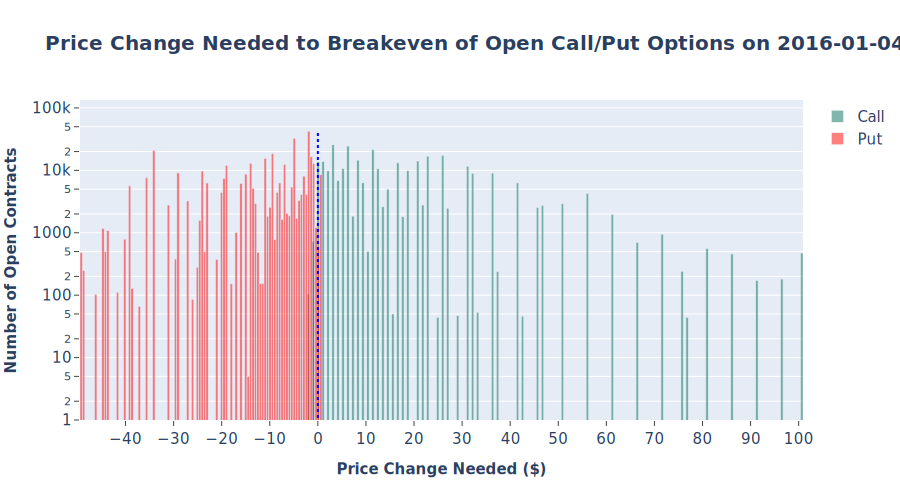

In [35]:
fig = go.Figure()
date = np.unique(options_df["date"])[0]

for my_df in [calls_df, puts_df]:
    temp_df = my_df[(my_df["date"] == date) & (my_df["open interest"] > 0)].reset_index(drop=True)

    my_min = np.min(temp_df["auto delta price"])
    my_max = np.max(temp_df["auto delta price"])

    # bins used for histogram
    [my_bins, my_step] = np.linspace(start=my_min,
                                     stop=my_max,
                                     num=num_bars + 1,
                                     retstep=True)
    # Obtain which bin each adjusted breakeven price / change per day belongs
    my_indices = np.digitize(x=temp_df["auto delta price"],
                             bins=my_bins,
                             right=True)
    # Subtract one since indices start with "1"
    my_indices = my_indices - 1
    # Obtain axis for plotting
    x_axis = np.linspace(start=my_min + 0.5 * my_step,
                         stop=my_max - 0.5 * my_step,
                         num=num_bars)

    y_axis = pd.Series(np.zeros(num_bars))

    for n in range(temp_df.shape[0]):
        y_axis.iloc[my_indices[n]] += temp_df.loc[n, "open interest"]

    if all(temp_df["type"] == "call"):
        my_color = "rgb(1, 110, 90)"
        my_legend = "Call"
    else:
        my_color = "rgb(255, 0, 0)"
        my_legend = "Put"

    fig.add_trace(go.Bar(x=x_axis,
                         y=y_axis,
                         marker_color=my_color,
                         name=my_legend,
                         opacity=0.5,
                         width=0.5))

fig.add_shape(dict(
    type="line",
    x0=0,
    y0=0,
    x1=0,
    y1=max(y_axis),
    line=dict(
        color="blue",
        dash="dot",
        width=2
    )
))

fig.update_layout(
    title=dict(text="<b>Price Change Needed to Breakeven of Open Call/Put Options on <b>"
                    + str(date),
               font=dict(size=20)),
    xaxis_title=dict(text="<b>Price Change Needed ($)<b>",
                     font=dict(size=15)),
    yaxis_title=dict(text="<b>Number of Open Contracts<b>",
                     font=dict(size=15)),
    font=dict(size=15)
)

fig.update_yaxes(type="log",
                 range=[0, np.log10(max(y_axis)) + 0.5],
                 ticks="outside",
                 automargin=True)

fig.update_xaxes(nticks = 20,
                 ticks="outside",
                 automargin=True)

fig.show("svg", width=900, height=500)

**Observations**
<br>
There are minor amounts of call options requiring a negative price change, and put options requiring a positive price change to breakeven. The largest culprit of this issue is the use of "bid price" to gauge option premium, which is susceptible to "low-ball" bids that would never be filled. In addition, options that are either extremely ITM or OTM often have very low volumes, and the use of outdated data for those options can also be a cause.

### Feature Engineering
To track the general sentiment of the market towards the price movement of a stock, I believe that tracking the volume and open interest of the same options over the course of its lifespan is a good place to start.

**Remarks regarding "open interest" and "volume"**

My initial intention had been to calculate both the number of "buys" and number "sells" of a given option over the course of one day. However, upon closer observation, we realized that the data was flawed. By definition, the open interest should be the number of open contracts recorded at the end of the business day. Therefore, by definition, the volume of an option on day `n` should be greater or equal to the change in open interest from day `n-1` and day `n`. This is due to volume being an absolute number of transactions for the day. When observing the data, we realized that the change in open interest between day `n-1` and day `n`corresponds much better to the volume of day `n-1`, rather than day `n`. This suggests that open interest was recorded at the start of market date rather than the end. There is also the possibility that the recorded volume was simply lagging by one day, such that the volume recorded for day `n-1` was really the volume for day `n`. However, I find the former of the two possibilities more likely.
<br>
<br>
I have demonstrated this by comparing the number of options that experienced a change in open interest greater than the recorded volume below.

In [36]:
# Separate interest DataFrames for calls and puts
calls_interest = pd.DataFrame()
puts_interest = pd.DataFrame()

for my_df in [calls_df, puts_df]:
    # Temporary DataFrame to hold change in open interest info
    temp_df = pd.DataFrame()
    # All dates, sorted
    date_index = sorted(np.unique(my_df["date"]))

    # range(int(len(date_index) - 1))
    for my_index in range(int(len(date_index) - 1)):
        # Extract open interest for previous day & rename
        current_oi = my_df[my_df["date"] == date_index[my_index]] \
            [["date", "expiration date", "days till exp", "strike price", "open interest", "volume", "price", "adj delta price", "raw delta price", "auto delta price", "adj closing"]]
        current_oi = current_oi.rename(columns={"open interest": "current day open interest",
                                                "volume": "current day volume"})

        # Remove options that would expire the following day
        current_oi = current_oi[current_oi["expiration date"] >= date_index[my_index + 1]]

        # Extract open interest for today & rename
        next_oi = my_df[my_df["date"] == date_index[my_index + 1]] \
            [["expiration date", "strike price", "open interest", "volume"]]
        next_oi = next_oi.rename(columns={"open interest": "next day open interest",
                                                "volume": "next day volume"})

        # Use outer join since there are some options that didn't exist today but does tomorrow (prob due to after hours trading)
        # also some cases where option exists today but not tomorrow (all open contracts were exercised ...etc)
        joined_df = pd.merge(left=current_oi, right=next_oi,
                             on=["expiration date", "strike price"], how="outer", sort=False)

        # For new options that appeared during that day, we fill in several columns
        joined_df["date"] = joined_df["date"].fillna(value=date_index[my_index])
        joined_df[["current day volume", "current day open interest"]] = \
            joined_df[["current day volume", "current day open interest"]].fillna(value=0)

        joined_df["delta interest"] = joined_df["next day open interest"] - joined_df["current day open interest"]

        # Append joined matrix
        temp_df = temp_df.append(
            joined_df[["date", "expiration date", "days till exp", "strike price",
                       "adj delta price", "raw delta price", "auto delta price",
                       "delta interest", "current day volume", "next day volume",
                       "current day open interest", "next day open interest", "price", "adj closing"]]) \
            .reset_index(drop=True)

    # This is dependent on call & put order from above
    if calls_interest.empty:
        calls_interest = temp_df
    else:
        puts_interest = temp_df

In [37]:
put_temp_int = puts_interest[np.abs(puts_interest["delta interest"]) > puts_interest["current day volume"]].shape[0]
call_temp_int = calls_interest[np.abs(calls_interest["delta interest"]) > calls_interest["current day volume"]].shape[0]

print("For our ticker " + stock_of_interest + " put options in the year 2016, there are " +
      str(put_temp_int) + " options when the difference in open interest between days `n-1` and `n` is greater than the volume on day `n-1`.")
print("For call options, there are " + str(call_temp_int) + " cases.")


For our ticker CVX put options in the year 2016, there are 585 options when the difference in open interest between days `n-1` and `n` is greater than the volume on day `n-1`.
For call options, there are 431 cases.


In [38]:
put_temp_int = puts_interest[np.abs(puts_interest["delta interest"]) > puts_interest["next day volume"]].shape[0]
call_temp_int = calls_interest[np.abs(calls_interest["delta interest"]) > calls_interest["next day volume"]].shape[0]

print("For our ticker " + stock_of_interest + " put options in the year 2016, there are " +
      str(put_temp_int) + " options when the difference in open interest between days `n-1` and `n` is greater than the volume on day `n`.")
print("For call options, there are " + str(call_temp_int) + " cases.")

For our ticker CVX put options in the year 2016, there are 16935 options when the difference in open interest between days `n-1` and `n` is greater than the volume on day `n`.
For call options, there are 13425 cases.


Although the probability that open interest is recorded at the beginning of the day is much more likely, we have yet to explain the smaller proportion of cases where the volume still doesn't add up. I suspect that this is largely due to pre and post market trading.
<br>
<br>
Ultimately, we will be using the change in open interest as the measure for "volume", as it is the best display of overall change in interest of a given option.

In [39]:
print("Daily change in interest for call options:")
calls_interest.head()

Daily change in interest for call options:


,date,expiration date,days till exp,strike price,adj delta price,raw delta price,auto delta price,delta interest,current day volume,next day volume,current day open interest,next day open interest,price,adj closing
0,2016-01-04,2016-01-08,4.0,70.0,-1.470164,-1.40,-1.40,0.0,0.0,0.0,1.0,1.0,17.45,88.271148
1,2016-01-04,2016-01-08,4.0,80.0,-1.320164,-1.25,-1.25,0.0,0.0,0.0,1.0,1.0,7.60,88.271148
2,2016-01-04,2016-01-08,4.0,81.0,-1.270164,-1.20,-1.20,0.0,0.0,0.0,20.0,20.0,6.65,88.271148
3,2016-01-04,2016-01-08,4.0,81.5,-1.270164,-1.20,-1.20,0.0,0.0,0.0,24.0,24.0,6.15,88.271148
4,2016-01-04,2016-01-08,4.0,82.0,0.129836,0.20,0.20,-6.0,10.0,0.0,28.0,22.0,7.05,88.271148


In [40]:
print("Daily change in interest for put options:")
puts_interest.head()

Daily change in interest for put options:


,date,expiration date,days till exp,strike price,adj delta price,raw delta price,auto delta price,delta interest,current day volume,next day volume,current day open interest,next day open interest,price,adj closing
0,2016-01-04,2016-01-08,4.0,65.0,-23.930164,-23.86,-23.930164,0.0,0.0,0.0,13.0,13.0,0.01,88.271148
1,2016-01-04,2016-01-08,4.0,70.0,-18.960164,-18.89,-18.960164,0.0,0.0,0.0,173.0,173.0,0.04,88.271148
2,2016-01-04,2016-01-08,4.0,75.0,-13.940164,-13.87,-13.940164,60.0,162.0,685.0,1506.0,1566.0,0.02,88.271148
3,2016-01-04,2016-01-08,4.0,76.5,-12.440164,-12.37,-12.440164,291.0,291.0,11.0,11.0,302.0,0.02,88.271148
4,2016-01-04,2016-01-08,4.0,77.0,-11.960164,-11.89,-11.960164,0.0,3.0,0.0,50.0,50.0,0.04,88.271148


Here, I've noticed that there are cases where a certain option does not exist on day `n-1`, but would suddenly exist on day `n` with a non-zero open interest. I suspect that this is due to pre/post market trading, as the vast majority of newly listed options have an open interest of 0. Below I have printed the number of options that satisfy each case below. For both situations, I will simply remove the options. For the common trivial case when the newly listed option has no open interest, "delta interest" would be 0 anyway. We will not deal with the non-trivial case since we would have to derive various features again.

In [41]:
temp_put_triv = puts_interest[(puts_interest["price"].isnull()) &
                             (puts_interest["next day open interest"] == 0)].shape[0]

temp_put_total = puts_interest[(puts_interest["price"].isnull())].shape[0]

temp_call_triv = calls_interest[(calls_interest["price"].isnull()) &
                               (calls_interest["next day open interest"] == 0)].shape[0]

temp_call_total = calls_interest[(calls_interest["price"].isnull())].shape[0]

print("For our ticker " + stock_of_interest + " put options in the year 2016, there are " +
      str(temp_put_total - temp_put_triv) + " cases of options appearing with non-zero initial open interest. " +
      str(temp_put_triv) + " cases of new options with zero initial open interest.")

print("For our ticker " + stock_of_interest + " call options in the year 2016, there are " +
      str(temp_call_total - temp_call_triv) + " cases of options appearing with non-zero initial open interest. " +
      str(temp_call_triv) + " cases of new options with zero initial open interest.")

For our ticker CVX put options in the year 2016, there are 71 cases of options appearing with non-zero initial open interest. 2106 cases of new options with zero initial open interest.
For our ticker CVX call options in the year 2016, there are 39 cases of options appearing with non-zero initial open interest. 1815 cases of new options with zero initial open interest.


In [42]:
# Removing newly appearing call/put options
puts_interest = puts_interest[puts_interest["price"].notna()]
calls_interest = calls_interest[calls_interest["price"].notna()]

In addition to the above problem, we realize that we cannot detect whether a change in open interest is due to market trading or exercising of the underlying options, as exercised options should not count towards volume - they are not reflective of market demand for that option, merely the obligation of the writer. Although one could argue that the act of exercising qualifies as a market sentiment (e.g. exercise call option in anticipation price will drop), we will not explore this now, as selling the option usually involves fewer fees.

Here, I will assume that all options that suddenly disappear from day `n-1` to `n` are simply exercised. The reason behind removing the option altogether as opposed setting the missing "open interest" of day `n` to be 0 can be attributed to the days upon which the disappearances happen most often as shown below.

Below I have printed the number of option listings that disappear the following day.

In [43]:
temp_df = calls_interest[calls_interest["next day open interest"].isnull()]
print("Total number of call option 'disappearances' for ticker " + stock_of_interest + ": " + str(temp_df.shape[0]))
print("Most frequent days:")
temp_df.date.value_counts()

Total number of call option 'disappearances' for ticker CVX: 262
Most frequent days:


2016-05-16    58
2016-08-16    45
2016-11-15    41
2016-02-12    28
2016-12-22     5
              ..
2016-10-14     1
2016-05-18     1
2016-02-19     1
2016-07-21     1
2016-08-22     1
Name: date, Length: 70, dtype: int64

In [44]:
temp_df = puts_interest[puts_interest["next day open interest"].isnull()]
print("Total number of put option 'disappearances' for ticker " + stock_of_interest + ": " + str(temp_df.shape[0]))
print("Most frequent days:")
temp_df.date.value_counts()

Total number of put option 'disappearances' for ticker CVX: 200
Most frequent days:


2016-12-15    25
2016-12-29    22
2016-03-29     5
2016-03-15     5
2016-03-03     3
              ..
2016-03-28     1
2016-07-14     1
2016-07-21     1
2016-11-04     1
2016-12-28     1
Name: date, Length: 110, dtype: int64

From the above, we observe that, days with the most disappearing options happen on the days immediately prior to the ex-dividend date. This only happens with ITM call options, since the holder is able to secure the dividend for that quarter (they are assuming that the dividend amount outweighs the price change from ex-div to expiry).

Although a counter argument can be made for put options, that ITM put holders should exercise on, or immediately after, the ex-dividend date, as there is a theoretical price drop, this effect is not as prominent.

In [45]:
# Removing exercised options
puts_interest = puts_interest[puts_interest["next day open interest"].notna()]
calls_interest = calls_interest[calls_interest["next day open interest"].notna()]

However, it is important to remind our inability to distinguish between trades and exercise for all other cases. Because of this, outside of options that "disappear" overnight, all other option volume will be attributed to trading.

In [46]:
calls_volume = calls_interest[["date", "delta interest"]].copy()
calls_volume["delta interest"] = np.abs(calls_volume["delta interest"])
calls_volume = calls_volume.groupby(["date"]).sum()

puts_volume = puts_interest[["date", "delta interest"]].copy()
puts_volume["delta interest"] = np.abs(puts_volume["delta interest"])
puts_volume = puts_volume.groupby(["date"]).sum()

Below are two plots showing the volume of call and put options throughout the course of the year. Note that the ex-dividend dates are explicitly declared for ticker `CVX`, and will need to read from `data/dividends` folder to be fully automated.

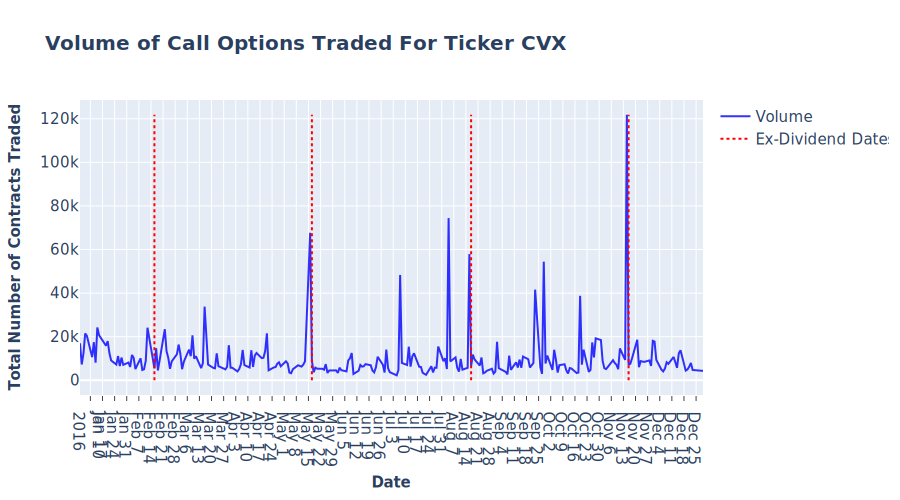

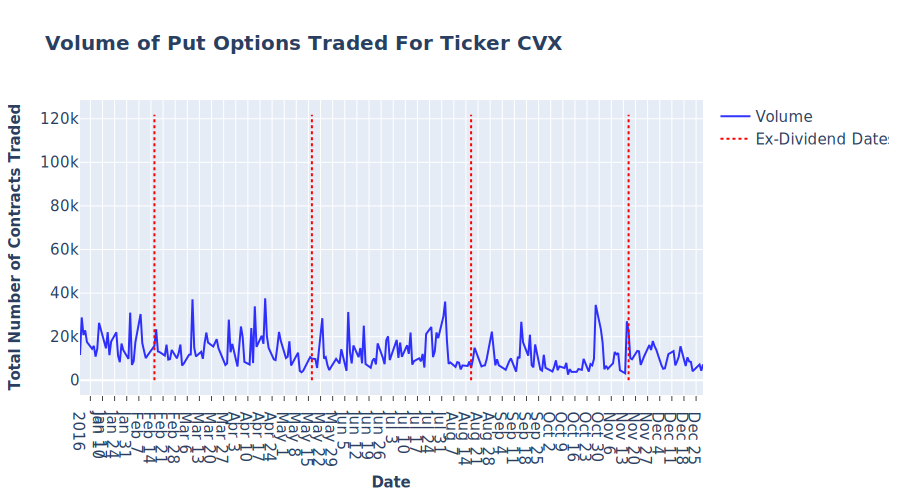

In [47]:
fig1 = go.Figure()
fig2 = go.Figure()

fig1.add_trace(go.Scatter(
    x = calls_volume.index,
    y = calls_volume["delta interest"],
    name = "Volume",
    marker_color="blue",
    opacity=0.8,
    connectgaps = True
))

fig2.add_trace(go.Scatter(
    x = puts_volume.index,
    y = puts_volume["delta interest"],
    name = "Volume",
    marker_color="blue",
    opacity=0.8,
    connectgaps = True
))

for my_fig in [fig1, fig2]:
    if my_fig == fig1:
        my_type = "Call"
    else:
        my_type = "Put"

    my_fig.update_layout(
        title=dict(text="<b>Volume of <b>" + my_type +
                        "<b> Options Traded For Ticker <b>" +
                        stock_of_interest,
                   font=dict(size=20)),
        xaxis_title=dict(text="<b>Date<b>",
                         font=dict(size=15)),
        yaxis_title=dict(text="<b>Total Number of Contracts Traded<b>",
                         font=dict(size=15)),
        font=dict(size=15)
    )

    my_fig.add_trace(go.Scatter(
        x = [datetime.date(2016, 2, 16),
             datetime.date(2016, 2, 16),
             datetime.date(2016, 2, 16),
             datetime.date(2016, 5, 17),
             datetime.date(2016, 5, 17),
             datetime.date(2016, 5, 17),
             datetime.date(2016, 8, 17),
             datetime.date(2016, 8, 17),
             datetime.date(2016, 8, 17),
             datetime.date(2016,11, 16),
             datetime.date(2016,11, 16),
             datetime.date(2016,11, 16)],
        y = [0, max(calls_volume["delta interest"]), None,
             0, max(calls_volume["delta interest"]), None,
             0, max(calls_volume["delta interest"]), None,
             0, max(calls_volume["delta interest"]), None],
        mode = "lines",
        name = "Ex-Dividend Dates",
        line=dict(
            color="red",
            dash="dot",
            width=2
        )
    ))

    my_fig.update_xaxes(nticks = 120,
                        ticks="outside",
                        automargin=True)

    my_fig.show("svg", width=900, height=500)

Now I will export the call and put option data we have created and filtered. This is mostly because this script is getting too long and will take significant time/memory to run from scratch every time.

In [48]:
Path(default_save_path).mkdir(exist_ok=True)

calls_interest.to_csv(path_or_buf=(default_save_path + stock_of_interest +
                                   "_calls_EDA1.csv"),
                      index=False)

puts_interest.to_csv(path_or_buf=(default_save_path + stock_of_interest +
                                   "_puts_EDA1.csv"),
                     index=False)
